# Match cell size data with taxonomy

In [1]:
import lzma

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
from scipy.stats.mstats import gmean

In [4]:
%matplotlib inline

In [5]:
#!mkdir -p annot

### Data table

In [6]:
df = pd.read_table('data.tsv', index_col=0)
df.head()

,designation,strain,type_strain,species,shape,reference,taxid,length,width,volume,surface
ID,,,,,,,,,,,
159837,OUC007,"KCTC 52933, MCCC 1K03450, OUC007",1,Abyssibacter profundi,rod-shaped,66716,2182787.0,1.797220,0.489898,0.307987,2.766029
132478,L81,"DSM 29592, JCM 30920",1,Abyssivirga alkaniphila,rod-shaped,43989,1675854.0,3.162278,0.500000,0.588187,4.967294
24718,FYK2218,"DSM 28897, KCTC 12899, NBRC 101209",1,Acanthopleuribacter pedis,rod-shaped,32501,442870.0,3.358571,0.836660,1.693145,8.827819
7517,CSC,"DSM 14247, CCUG 49701, NBRC 107788, CIP 109141",1,Acaricomes phytoseiuli,coccus-shaped,31628,291968.0,1.224745,0.632456,0.318534,2.433467
134101,Z7,"JCM 12359, AS1.5012",1,Acetanaerobacterium elongatum,rod-shaped,31285,258515.0,6.000000,0.300000,0.417046,5.654867


In [7]:
df.shape[0]

4908

### Reference taxonomy

Read NCBI taxonomy database.

In [8]:
dump = {}
with lzma.open('nodes.dmp.xz', 'rb') as f:
    for line in f.read().decode().splitlines():
        x = line.rstrip('\r\n').replace('\t|', '').split('\t')
        dump[x[0]] = {'parent': x[1], 'rank': x[2], 'name': '', 'children': set()}
with lzma.open('names.dmp.xz', 'rb') as f:
    for line in f.read().decode().splitlines():
        x = line.rstrip('\r\n').replace('\t|', '').split('\t')
        if x[3] == 'scientific name':
            dump[x[0]]['name'] = x[1]
for tid in dump:
    pid = dump[tid]['parent']
    if tid != pid:
        dump[pid]['children'].add(tid)

In [9]:
len(dump)

2375861

### Match by taxon name

Match TaxID

In [10]:
tids = df['taxid']

In [11]:
np.unique(tids[tids.notna()].index.astype(str).isin(dump), return_counts=True)

(array([False,  True]), array([1328, 2884]))

Match species name

In [12]:
spnames = {v['name']: k for k, v in dump.items() if v['rank'] == 'species'}

In [13]:
df['species'].isin(spnames).value_counts()

True     4737
False     171
Name: species, dtype: int64

Therefore, it is a better idea to match by species name.

Add species TaxID.

In [14]:
df['sptid'] = df['species'].map(spnames)

Match subspecies name

In [15]:
sspnames = {v['name']: k for k, v in dump.items() if v['rank'] == 'subspecies'}

In [16]:
df[df['sptid'].isna()]['species'].isin(sspnames).value_counts()

False    160
True      11
Name: species, dtype: int64

Elevate subspecies to species.

In [17]:
def get_species(tid):
    if dump[tid]['rank'] == 'species':
        return tid
    return get_species(dump[tid]['parent'])

Add species TaxID of subspecies.

In [18]:
for idx, val in df[df['sptid'].isna()]['species'].iteritems():
    if val in sspnames:
        df.at[idx, 'sptid'] = get_species(sspnames[val])

### Match by TaxID

Check the remaining

In [19]:
df_ = df[df['sptid'].isna()].dropna(subset=['taxid'])[['species', 'taxid']].copy()
df_['taxid'] = df_['taxid'].astype(int).astype(str)
df_.head()

,species,taxid
ID,,
140290,Actinomyces liubingyangii,1921764
158436,Actinomyces tangfeifanii,1912795
22982,Adlercreutzia caecicola,747645
13647,Agrobacterium skierniewicense,1368417
134060,Algibacter wandonensis,1343161


In [20]:
df_.shape[0]

142

Check if these TaxIDs exist in taxdump.

In [21]:
df_ = df_[df_['taxid'].isin(dump)]
df_.shape[0]

138

Check if these TaxIDs are species.

In [22]:
dfx = df_[df_['taxid'].apply(lambda x: dump[x]['rank'] == 'species')]
dfx.shape[0]

119

Add species TaxIDs.

In [23]:
for idx, val in dfx['taxid'].iteritems():
    df.at[idx, 'sptid'] = val

If not species, check if they are lower than species.

In [24]:
dfx = df_[df_['taxid'].apply(lambda x: dump[x]['rank'] != 'species')]
dfx.shape[0]

19

In [25]:
dfx['taxid'].apply(lambda x: dump[x]['rank']).head()

ID
13647    strain
2095     strain
2099     strain
1225     strain
1254     strain
Name: taxid, dtype: object

Elevate ranks to species.

In [26]:
tids_ = dfx['taxid'].apply(get_species)

In [27]:
for idx, val in tids_.iteritems():
    df.at[idx, 'sptid'] = val

Work on remaining records.

In [28]:
df_ = df[df['sptid'].isna()]
df_.head()

,designation,strain,type_strain,species,shape,reference,taxid,length,width,volume,surface,sptid
ID,,,,,,,,,,,,
134060,WS-MY22,"KCTC 32381, CECT 8301",1,Algibacter wandonensis,rod-shaped,31156,1343161.0,3.300000,0.300000,0.226195,3.110177,NaN
140729,JSSK-8,"KCTC 52763, NBRC 112764",1,Altererythrobacter aquaemixtae,rod-shaped,43507,NaN,0.387298,0.282843,0.018411,0.344144,NaN
140987,CPA5,"CECT 9130, LMG 29519",1,Altererythrobacter halimionae,rod-shaped,43875,NaN,2.379160,0.692820,0.809860,5.178382,NaN
158561,C9-11,"MCCC 1K03311, JCM 32056",1,Altererythrobacter mangrovi,rod-shaped,65258,NaN,1.232883,0.424264,0.154302,1.643266,NaN
140815,WW3,"KCTC 42620, JCM 30975",1,Altererythrobacter rigui,rod-shaped,43603,NaN,0.604483,0.493559,0.084175,0.937287,NaN


In [29]:
df_.shape[0]

22

### Manual curation

Manually curate these records.

In [30]:
tidmap = {'134060': '221126',
          '140729': '1958940',
          '140987': '1926630',
          '158561': '1982042',
          '140815': '1708790',
          '140743': '1476466',
          '158655': '1912871',
          '140702': '1904463',
          '158725': '1983720',
          '158610': '1707093',
          '141013': '2036016',
          '140739': '1505588',
          '158534': '1967665',
          '141131': '1462440',
          '140758': '1850444',
          '133146': '1542729',
          '134303': '81932',
          '140782': '1807134',
          '134174': '323273',
          '24597':  '1276936',
          '1496':   '698769'}

In [31]:
for key, val in tidmap.items():
    df.at[int(key), 'sptid'] = val

Note: one record: 158661 (TaxID = 2126556) is too new and the TaxID does not exist in the current record. So delete.

In [32]:
df = df.dropna(subset=['sptid'])
df.shape[0]

4907

### Cell shape

Check if cell shape is constant per species.

In [33]:
s = df.groupby('sptid')['shape'].nunique()
s[s > 1]

sptid
446660    2
Name: shape, dtype: int64

In [34]:
df.query('sptid == "446660"')

,designation,strain,type_strain,species,shape,reference,taxid,length,width,volume,surface,sptid
ID,,,,,,,,,,,,
3073,FJC-B9,"DSM 19450, CCUG 54925, JCM 14793, KCTC 15235",1,Adlercreutzia equolifaciens,ovoid-shaped,32379,446660.0,2.1,0.65,0.624948,4.288274,446660
3072,do03,"DSM 18785, JCM 14811, AHU 1763",1,Adlercreutzia equolifaciens subsp. celatus,rod-shaped,32059,394340.0,2.5,0.45,0.373751,3.534292,446660


Check other members of the genus.

In [35]:
df[df['species'].str.startswith('Adlercreutzia')]

,designation,strain,type_strain,species,shape,reference,taxid,length,width,volume,surface,sptid
ID,,,,,,,,,,,,
22982,NR06,"DSM 22242, CCUG 57646, KCTC 15365",1,Adlercreutzia caecicola,rod-shaped,30824,747645.0,1.5,0.50,0.261799,2.356194,747645
3077,B7,"DSM 21839, CCUG 56815",1,Adlercreutzia caecimuris,rod-shaped,29529,1235794.0,2.0,0.50,0.359974,3.141593,671266
3073,FJC-B9,"DSM 19450, CCUG 54925, JCM 14793, KCTC 15235",1,Adlercreutzia equolifaciens,ovoid-shaped,32379,446660.0,2.1,0.65,0.624948,4.288274,446660
3072,do03,"DSM 18785, JCM 14811, AHU 1763",1,Adlercreutzia equolifaciens subsp. celatus,rod-shaped,32059,394340.0,2.5,0.45,0.373751,3.534292,446660
3076,Mt1B8,"DSM 19490, CCUG 54980",1,Adlercreutzia mucosicola,rod-shaped,28980,580026.0,2.0,0.50,0.359974,3.141593,580026


Manually assign it to be rod-shaped (according to majority voting).

In [36]:
df.at[3073, 'shape'] = 'rod-shaped'

In [37]:
shapes = dict(df[['sptid', 'shape']].drop_duplicates('sptid').values)

### Mean cell size

Check duplicate species.

In [38]:
df['sptid'].value_counts().value_counts()

1    4847
2      24
3       4
Name: sptid, dtype: int64

Group organisms by species TaxID and calculate geometric mean per species.

In [39]:
cols = ['length', 'width', 'volume', 'surface']

In [40]:
dfr = df.groupby('sptid')[cols].agg(gmean)

Add shape and species name.

In [41]:
dfr['shape'] = dfr.index.map(shapes)

In [42]:
dfr['species'] = dfr.index.to_series().apply(lambda x: dump[str(x)]['name'])

Organize.

In [43]:
dfr = dfr.loc[sorted(dfr.index, key=int)]

In [44]:
dfr.index.names = ['taxid']

In [45]:
dfr.head()

,length,width,volume,surface,shape,species
taxid,,,,,,
11,2.371708,1.060660,1.783187,7.902917,rod-shaped,Cellulomonas gilvus
14,10.000000,0.489898,1.854174,15.390598,rod-shaped,Dictyoglomus thermophilum
23,1.500000,0.700000,0.487470,3.298672,rod-shaped,Shewanella colwelliana
104,1.039230,0.346410,0.087062,1.130973,ring-shaped,Cyclobacterium marinum
148,67.082039,0.244949,3.157319,51.621635,NaN,Sediminispirochaeta bajacaliforniensis


Fill more ranks

In [46]:
ranks = ['species', 'genus', 'family', 'order', 'class', 'phylum', 'superkingdom']

In [47]:
res = {x: {} for x in ranks[1:]}

In [48]:
rankset = set(ranks[1:])

In [49]:
for tid in dfr.index.astype(str):
    this = tid
    while True:
        rank = dump[this]['rank']
        if rank in rankset:
            res[rank][tid] = dump[this]['name']
        parent = dump[this]['parent']
        if this == parent:
            break
        this = parent

In [50]:
for rank in ranks[1:]:
    dfr[rank] = dfr.index.map(res[rank])

In [51]:
dfr.head()

,length,width,volume,surface,shape,species,genus,family,order,class,phylum,superkingdom
taxid,,,,,,,,,,,,
11,2.371708,1.060660,1.783187,7.902917,rod-shaped,Cellulomonas gilvus,Cellulomonas,Cellulomonadaceae,Micrococcales,Actinomycetia,Actinobacteria,Bacteria
14,10.000000,0.489898,1.854174,15.390598,rod-shaped,Dictyoglomus thermophilum,Dictyoglomus,Dictyoglomaceae,Dictyoglomales,Dictyoglomia,Dictyoglomi,Bacteria
23,1.500000,0.700000,0.487470,3.298672,rod-shaped,Shewanella colwelliana,Shewanella,Shewanellaceae,Alteromonadales,Gammaproteobacteria,Proteobacteria,Bacteria
104,1.039230,0.346410,0.087062,1.130973,ring-shaped,Cyclobacterium marinum,Cyclobacterium,Cyclobacteriaceae,Cytophagales,Cytophagia,Bacteroidetes,Bacteria
148,67.082039,0.244949,3.157319,51.621635,NaN,Sediminispirochaeta bajacaliforniensis,Sediminispirochaeta,Spirochaetaceae,Spirochaetales,Spirochaetia,Spirochaetes,Bacteria


Output

In [52]:
dfr.to_csv('annot/species.tsv', sep='\t')

Statistics

In [53]:
for rank in ranks:
    print(rank, dfr[rank].nunique())

species 4875
genus 1665
family 384
order 160
class 68
phylum 32
superkingdom 2


In [54]:
dfr[dfr['phylum'] == 'Cyanobacteria']

,length,width,volume,surface,shape,species,genus,family,order,class,phylum,superkingdom
taxid,,,,,,,,,,,,
582514,3.427827,1.161895,3.223835,12.512258,rod-shaped,Rubidibacter lacunae,Rubidibacter,Aphanothecaceae,Chroococcales,NaN,Cyanobacteria,Bacteria


### Entire NCBI

This table includes all non-duplicate genomes hosted at NCBI RefSeq and GenBank.

In [55]:
dfa = pd.read_table('all_ranks.tsv.xz', index_col=0)
dfa.head()

,superkingdom,kingdom,phylum,class,order,family,genus,species
genome,,,,,,,,
G000001985,Eukaryota,Fungi,Ascomycota,Eurotiomycetes,Eurotiales,Trichocomaceae,Talaromyces,Talaromyces marneffei
G000002415,Eukaryota,NaN,Apicomplexa,Aconoidasida,Haemosporida,Plasmodiidae,Plasmodium,Plasmodium vivax
G000002435,Eukaryota,NaN,Fornicata,NaN,Diplomonadida,Hexamitidae,Giardia,Giardia intestinalis
G000002445,Eukaryota,NaN,Euglenozoa,Kinetoplastea,Trypanosomatida,Trypanosomatidae,Trypanosoma,Trypanosoma brucei
G000002455,Eukaryota,NaN,Cercozoa,Chlorarachniophyceae,NaN,NaN,Bigelowiella,Bigelowiella natans


In [56]:
dfa.shape[0]

1114893

In [57]:
proks = ['Bacteria', 'Archaea']

In [58]:
dfa.query('superkingdom == @proks', inplace=True)
dfa.shape[0]

1063134

In [59]:
for rank in ranks:
    print(rank, dfa[rank].nunique())

species 60407
genus 3950
family 673
order 296
class 139
phylum 200
superkingdom 2


In [60]:
bins = [1, 10, 100, 1000, 10000, 100000, 1000000]

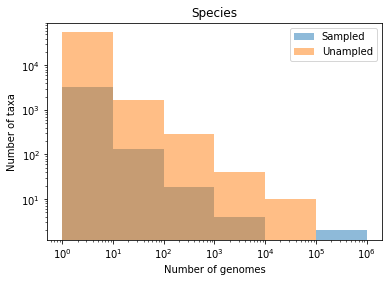

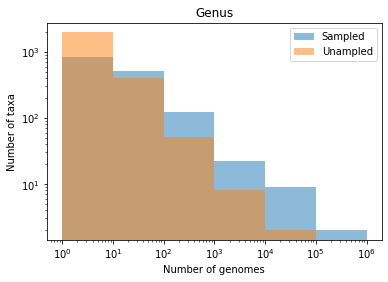

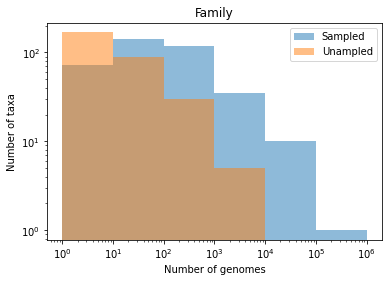

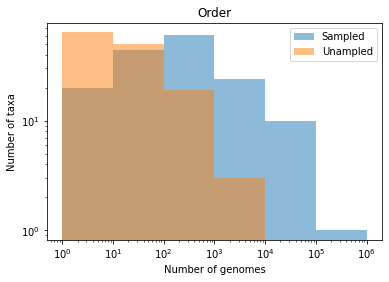

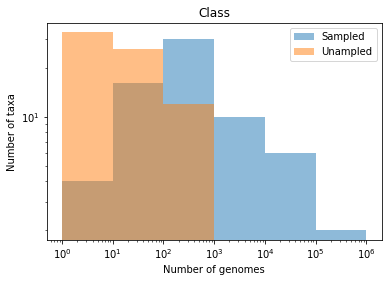

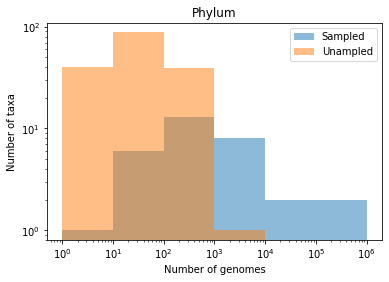

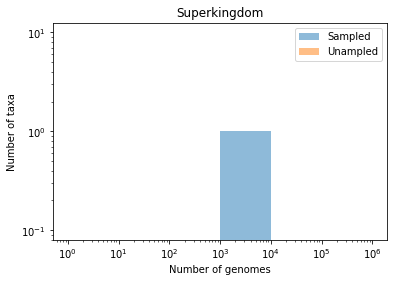

In [61]:
for rank in ranks:
    counts = dfa[rank].value_counts().rename('all').to_frame()
    counts['sampled'] = counts.index.map(dfr[rank].value_counts()).fillna(0).astype(int)
    plt.hist(counts.query('sampled != 0')['all'], bins=bins, alpha=0.5, log=True, label='Sampled')
    plt.hist(counts.query('sampled == 0')['all'], bins=bins, alpha=0.5, log=True, label='Unampled')
    plt.xscale('log')
    plt.xlabel('Number of genomes')
    plt.ylabel('Number of taxa')
    plt.legend()
    plt.title(rank.capitalize())
    plt.show()

Top 10 species

In [62]:
rank = 'species'

In [63]:
counts = dfa[rank].value_counts().rename('all').to_frame()
counts['sampled'] = counts.index.map(dfr[rank].value_counts()).fillna(0).astype(int)
counts.sort_values('all', ascending=False).head(10)

,all,sampled
Salmonella enterica,375417,1
Escherichia coli,142518,1
Campylobacter jejuni,48171,0
Listeria monocytogenes,44033,0
Staphylococcus aureus,25850,0
Streptococcus pneumoniae,22491,0
Campylobacter coli,19807,0
Klebsiella pneumoniae,16037,0
Enterococcus faecium,13070,0
Shigella sonnei,12267,0


### Collapse to higher ranks

In [64]:
df.head()

,designation,strain,type_strain,species,shape,reference,taxid,length,width,volume,surface,sptid
ID,,,,,,,,,,,,
159837,OUC007,"KCTC 52933, MCCC 1K03450, OUC007",1,Abyssibacter profundi,rod-shaped,66716,2182787.0,1.797220,0.489898,0.307987,2.766029,2182787
132478,L81,"DSM 29592, JCM 30920",1,Abyssivirga alkaniphila,rod-shaped,43989,1675854.0,3.162278,0.500000,0.588187,4.967294,1675854
24718,FYK2218,"DSM 28897, KCTC 12899, NBRC 101209",1,Acanthopleuribacter pedis,rod-shaped,32501,442870.0,3.358571,0.836660,1.693145,8.827819,442870
7517,CSC,"DSM 14247, CCUG 49701, NBRC 107788, CIP 109141",1,Acaricomes phytoseiuli,coccus-shaped,31628,291968.0,1.224745,0.632456,0.318534,2.433467,291968
134101,Z7,"JCM 12359, AS1.5012",1,Acetanaerobacterium elongatum,rod-shaped,31285,258515.0,6.000000,0.300000,0.417046,5.654867,258515


In [65]:
def get_rank(tid, rank):
    if tid == '1':
        return None
    if dump[tid]['rank'] == rank:
        return tid
    return get_rank(dump[tid]['parent'], rank)

In [66]:
for rank in ranks[1:]:
    dfr = df.copy().drop(columns=['taxid'])
    dfr['taxid'] = dfr['sptid'].apply(lambda x: get_rank(x, rank))
    dfr = dfr.dropna(subset=['taxid'])
    dfr = dfr.groupby('taxid')[cols].agg(gmean)
    dfr = dfr.loc[sorted(dfr.index, key=int)]
    ranks_ = ranks[ranks.index(rank):]
    res = {x: {} for x in ranks_}
    rankset = set(ranks_)
    for tid in dfr.index.astype(str):
        this = tid
        while True:
            rank_ = dump[this]['rank']
            if rank_ in rankset:
                res[rank_][tid] = dump[this]['name']
            parent = dump[this]['parent']
            if this == parent:
                break
            this = parent
    for rank_ in ranks_:
        dfr[rank_] = dfr.index.map(res[rank_])
    dfr.to_csv(f'annot/{rank}.tsv', sep='\t')
    print(f'{rank}: {dfr.shape[0]}')

genus: 1665
family: 384
order: 160
class: 68
phylum: 32
superkingdom: 2
